## **Contents**
-  [Introduction](#i)
-  [1.Importing Libraries](#1)
-  [2.Helper Functions](#2)
-  [3.Dataset Managament](#3)
    -  [3.1.Dataset and DataLoaders](#3.1)
    -  [3.2.Visualizing Dataset](#3.2)
-  [4.Initializing pre-trained model](#4)
-  [5.Training](#5)
-  [6.Plotting Graphs](#6)
    -  [6.1.Plotting Loss vs Epoch](#6.1)
-  [7.Loading and Testing](#7)
-  [8.Predictions](#8)

## **Introduction** <a class="anchor" id="i"></a>


In this notebook I am visualizing the dataset and also training [U-Net](https://arxiv.org/abs/1505.04597) model using [Segmentation model](https://github.com/qubvel/segmentation_models.pytorch) library which is based on [Pytorch](https://pytorch.org/) library.  
Resnet34 net is being utilized for the U-Net trained in this notebook.

U-Net is an architecture for semantic segmentation. It consists of a contracting path and an expansive path. The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a 2x2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.


Read more about U-Net [here](https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5)

Some of the helper functions is derived from [this](https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net/notebook#Model:-U-net) notebook.

<img src= "https://miro.medium.com/max/953/1*Z98NhzbVISHa4CoemZS4Kw.png"  style='width: 700px;'>

### **1.Importing Libraries** <a class="anchor" id="1"></a>

In [1]:
#If you are running it in offline you can directly pip install segmentation_model

%%capture
!pip install ../input/segmentation-models-wheels/efficientnet_pytorch-0.6.3-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/timm-0.3.2-py3-none-any.whl
!pip install ../input/segmentation-models-wheels/segmentation_models_pytorch-0.1.3-py3-none-any.whl

In [2]:
import os
import torch
import random
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
import seaborn as sns
from PIL import Image
from PIL import Image
from sklearn import cluster
import torch.nn.functional as F
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from albumentations import (HorizontalFlip, VerticalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")

### **2.Helper Functions** <a class="anchor" id="2"></a>

In [3]:
IMG_SIZE = (224,224)
root = "../input/sartorius-cell-instance-segmentation/"

def rle_decode(mask_rle, shape, color=1):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def build_masks(df_train, image_id, input_shape):
    height, width = input_shape
    labels = df_train[df_train["id"] == image_id]["annotation"].tolist()
    mask = np.zeros((height, width))
    for label in labels:
        mask += rle_decode(label, shape=(height, width))
    mask = mask.clip(0, 1)
    return mask

def post_process(probability, threshold=0.5, min_size=300):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = []
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            a_prediction = np.zeros((520, 704), np.float32)
            a_prediction[p] = 1
            predictions.append(a_prediction)
    return predictions

# Stolen from: https://www.kaggle.com/arunamenon/cell-instance-segmentation-unet-eda
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# Modified by me

def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

def check_is_run_length(mask_rle):
    if not mask_rle:
        return True
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    start_prev = starts[0]
    ok = True
    for start in starts[1:]:
        ok = ok and start > start_prev
        start_prev = start
        if not ok:
            return False
    return True

def create_empty_submission():
    fs = os.listdir("../input/sartorius-cell-instance-segmentation/test")
    df = pd.DataFrame([(f[:-4], "") for f in fs], columns=['id', 'predicted'])
    df.to_csv("submission.csv", index=False)

### **3.Dataset Managament** <a class="anchor" id="3"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="3.1"></a>

In [4]:
class SatoriusDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, root = 'data/',train = True):
        self.root = root
        self.transforms = transforms
        self.w , self.h = 520 , 704
        info = pd.read_csv(self.root+'train.csv')[["id","annotation"]]
        info = info.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        validation =  30
        self.data_info = 0

        if train == True:
            self.data_info = info[validation:].reset_index(drop=True)
        else:
            self.data_info = info[:validation].reset_index(drop=True)
            
    def __getitem__(self, idx):
        img = Image.open(self.root+'train/'+self.data_info['id'][idx]+'.png').convert("RGB")
        labels = self.data_info['annotation'][idx]
        mask = np.zeros((self.w , self.h))
        for label in labels:
            mask = mask + rle_decode(label, shape=(self.w , self.h))
        mask = mask.clip(0, 1)
        mask = (mask >= 1).astype('float32')
        augmented = self.transforms(image=np.array(img), mask=mask)
        img = augmented['image']
        mask = augmented['mask']
        return img, mask.reshape((1, IMG_SIZE[0], IMG_SIZE[1]))

    def __len__(self):
        return len(self.data_info)


    
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(Resize(IMG_SIZE[0], IMG_SIZE[1]))
    transforms.append(Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))
        
    transforms.append(ToTensorV2())
    return Compose(transforms)


train_dataset = SatoriusDataset(transforms=get_transform(train=True),root =root,train = True)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

validation_dataset = SatoriusDataset(transforms=get_transform(train=False),root =root,train = False)
validation_dataloader = DataLoader(validation_dataset, batch_size=30, shuffle=False)

#### 2.Visualizing Dataset <a class="anchor" id="3.2"></a>

In [5]:
train_df = train_dataset.data_info
validation_df = validation_dataset.data_info

pd.set_option('max_colwidth', 125)
display(train_df.head())
display(validation_df)

,id,annotation
0,0ea6df67cc77,[257884 4 258586 9 259288 12 259992 13 260695 14 261399 15 262103 16 262807 17 263512 16 264216 17 264920 18 265625 17 26...
1,0eb1d03df587,"[38770 2 39473 5 40177 6 40880 8 41585 8 42291 8 42999 5 43704 4 44409 4 45113 4 45818 4 46522 4 47227 3 47932 2, 19788 3..."
2,0eca9ecf4987,[290412 5 291111 11 291814 12 292516 14 293219 15 293922 16 294625 17 295328 17 296030 19 296733 20 297436 20 298140 20 2...
3,0f08d640930b,[356486 6 357183 14 357885 16 358587 18 359289 20 359992 21 360695 22 361398 22 362101 23 362805 23 363510 22 364214 22 3...
4,0f2a46026693,[192272 3 192973 7 193676 9 194379 11 195082 13 195786 14 196490 14 197195 13 197900 12 198606 9 199311 7 200016 5 200722...


,id,annotation
0,0030fd0e6378,[118145 6 118849 7 119553 8 120257 8 120961 9 121665 10 122369 12 123074 13 123778 14 124482 15 125186 16 125890 17 12659...
1,0140b3c8f445,[32499 3 33201 7 33902 9 34604 10 35306 11 36009 11 36711 12 37414 12 38116 13 38819 13 39521 14 40224 14 40926 15 41629 ...
2,01ae5a43a2ab,[241026 3 241726 9 242427 13 243130 14 243834 15 244538 15 245241 16 245945 16 246649 16 247353 16 248057 16 248761 15 24...
3,026b3c2c4b32,[170753 5 171454 12 172158 13 172862 13 173565 14 174269 14 174973 14 175677 14 176381 14 177086 13 177790 13 178495 11 1...
4,029e5b3b89c7,[139142 7 139845 10 140548 13 141251 15 141955 15 142658 16 143361 16 144065 16 144769 16 145473 16 146177 15 146881 15 1...
5,0323e81d23d9,[244004 3 244705 8 245407 12 246109 15 246811 17 247514 18 248218 19 248921 20 249625 20 250329 20 251033 19 251738 18 25...
6,03b27b381a5f,[219219 3 219922 6 220625 8 221328 10 222031 11 222735 12 223438 14 224142 14 224846 16 225551 15 226255 15 226961 13 227...
7,042c17cd9143,[34611 1 35314 3 36016 5 36719 7 37422 8 38124 11 38827 14 39531 16 40236 17 40940 17 41645 16 42349 16 43054 15 43758 15...
8,042dc0e561a4,[191692 8 192395 11 193097 14 193800 14 194503 15 195207 14 195910 15 196614 14 197317 14 198020 13 198723 13 199425 13 2...
9,04928f0866b0,[128782 4 129476 14 130179 15 130883 14 131586 15 132290 15 132994 15 133699 13 134403 13 135107 13 135811 12 136515 10 1...


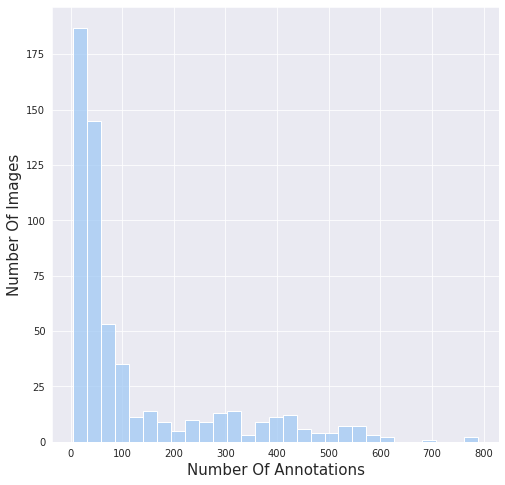

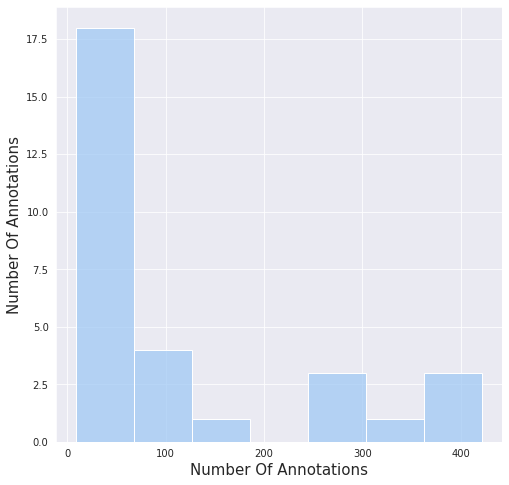

In [6]:
sns.set_palette("pastel")

n_annotations = [[],[]] #[[train], [validation]]
for i in train_df['annotation']:
    n_annotations[0].append(len(i))
    
for i in validation_df['annotation']:
    n_annotations[1].append(len(i))

x_axis,y_axis = 'Number Of Annotations' , 'Number Of Images'

fig = plt.figure(figsize=(8,8))
p = sns.histplot(data = n_annotations[0])
p.set_xlabel(x_axis, fontsize = 15)
p.set_ylabel(y_axis, fontsize = 15)


plt.show()

fig = plt.figure(figsize=(8,8))
p = sns.histplot(data = n_annotations[1])
p.set_xlabel(x_axis, fontsize = 15)
p.set_ylabel(x_axis, fontsize = 15)
plt.show()

Shape of Image : torch.Size([30, 3, 224, 224]) and Shape of Mask : torch.Size([30, 1, 224, 224])


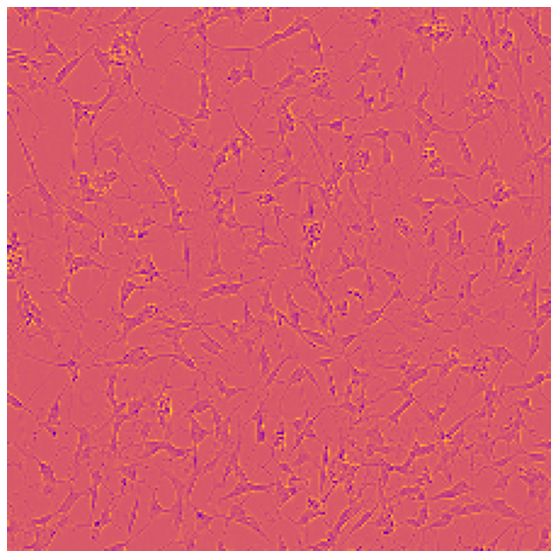

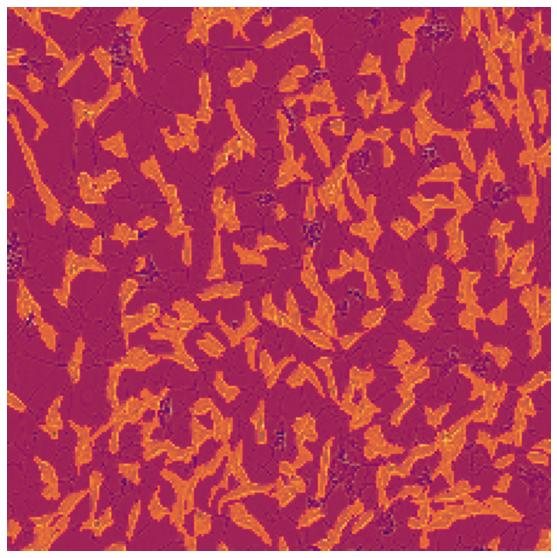

In [7]:
import cv2

img, mask = next(iter(validation_dataloader))
print(f'Shape of Image : {img.shape} and Shape of Mask : {mask.shape}')
image = np.array(img[0])[0]
mask = mask[0].reshape((IMG_SIZE[0], IMG_SIZE[1]))

plt.figure(figsize=(10, 10))
plt.imshow(image,cmap = 'plasma')
plt.axis("off")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(mask,alpha = 0.3,cmap = 'plasma')
plt.axis("off")
    
plt.show()

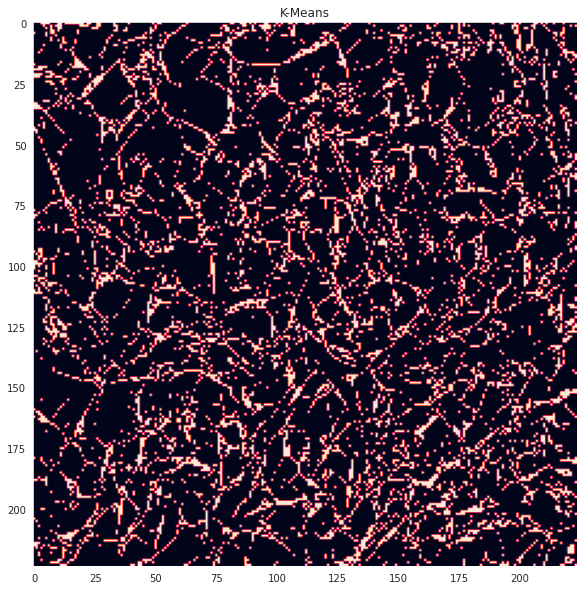

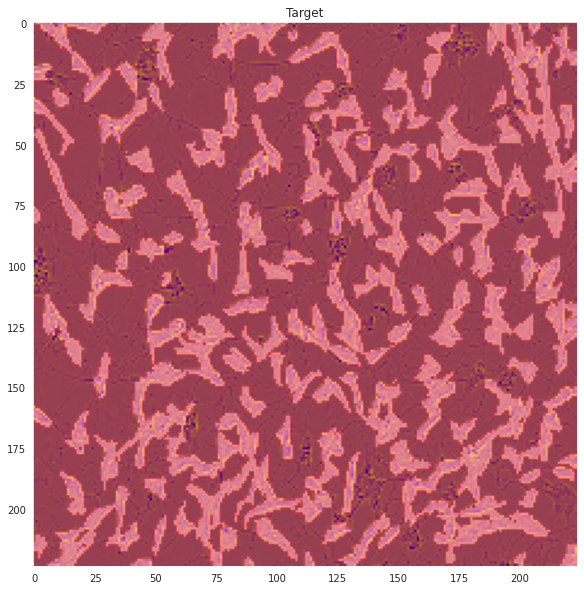

In [8]:
def clustered_img(x):
    kmeans = cluster.KMeans(2)
    dims = np.shape(x)
    pixel_matrix = np.reshape(x, (dims[0] * dims[1], dims[2]))
    clustered = kmeans.fit_predict(pixel_matrix)
    clustered_img = np.reshape(clustered, (dims[0], dims[1]))
    return clustered_img

for i in range(1):
    fig = plt.figure(figsize=(10,10))
    img, mask = next(iter(validation_dataloader))
    img = img[0]
    mask = mask[0].reshape((IMG_SIZE[0], IMG_SIZE[1]))
    plt.imshow(clustered_img(img.numpy().transpose((1,2,0))))
    plt.grid(None)
    plt.title("K-Means")
    plt.show()

    fig = plt.figure(figsize=(10,10))
    plt.imshow(img.numpy()[0],cmap = 'plasma')
    plt.imshow(mask, alpha=0.3)
    plt.grid(None)
    plt.title("Target")
    plt.show()

### **4.Initializing pre-trained model** <a class="anchor" id="4"></a>

In [9]:
# You need to add the below two lines only if you want to download pre trained models manually

!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/pytorch-pretrained-image-models/resnet34.pth /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth

import torch
import collections.abc as container_abcs
torch._six.container_abcs = container_abcs
import segmentation_models_pytorch as smp

In [10]:
import segmentation_models_pytorch as smp
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

In [11]:
device = 'cuda'
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00025)

epoch = 27
loss_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()

In [12]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()
    
criterion = MixedLoss(10.0, 2.0)

### **5.Training** <a class="anchor" id="5"></a>

In [13]:
model.train()
log_idx = 3

for e in range(epoch):
    for batch_idx , (images ,masks) in enumerate(train_dataloader):
        optimizer.zero_grad()
        images, masks = images.to(device),  masks.to(device)
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        if batch_idx % log_idx == 0:
            # Printing Log
            print(f'LOSS for EPOCH {e+1} BATCH {batch_idx+1}/{train_n_minibatches} TRAIN LOSS : {loss_history[0][-1]}',end = ' ')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                for _batch_idx_ , (images ,masks) in enumerate(validation_dataloader):
                    images, masks = images.to(device),  masks.to(device)
                    outputs = model(images)
                    validation_loss = criterion(outputs, masks)
                    loss_history[1].append(float(validation_loss.detach()))
                                      
                print(f'VALIDATION LOSS : {sum(loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}')

    torch.save(model.state_dict(),'unet_ss')
    #Log for e+1th epoch
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}')
    n_validation_losses = int(train_n_minibatches/log_idx)*validation_n_minibatches
    print(f'VALIDATION LOSS for EPOCH {e+1} : {sum(loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}',end = '\n')
    print('---------------------------------------------------------------------------------------------')

LOSS for EPOCH 1 BATCH 1/9 TRAIN LOSS : 3.2720186710357666 VALIDATION LOSS : 3.0966734886169434
LOSS for EPOCH 1 BATCH 4/9 TRAIN LOSS : 2.7219624519348145 VALIDATION LOSS : 2.6695523262023926
LOSS for EPOCH 1 BATCH 7/9 TRAIN LOSS : 2.5042026042938232 VALIDATION LOSS : 2.4359793663024902
---------------------------------------EPOCH 1-------------------------------------------
Loss for EPOCH 1  TRAIN LOSS : 2.700367318259345
VALIDATION LOSS for EPOCH 1 : 2.7340683937072754
---------------------------------------------------------------------------------------------
LOSS for EPOCH 2 BATCH 1/9 TRAIN LOSS : 2.2144060134887695 VALIDATION LOSS : 2.287933826446533
LOSS for EPOCH 2 BATCH 4/9 TRAIN LOSS : 2.1826112270355225 VALIDATION LOSS : 2.1805295944213867
LOSS for EPOCH 2 BATCH 7/9 TRAIN LOSS : 2.0884766578674316 VALIDATION LOSS : 2.0949759483337402
---------------------------------------EPOCH 2-------------------------------------------
Loss for EPOCH 2  TRAIN LOSS : 2.118213309182061
VALI

### **6.Plotting Graphs** <a class="anchor" id="6"></a>

#### 1.Plotting Loss vs Epoch<a class="anchor" id="6.1"></a>

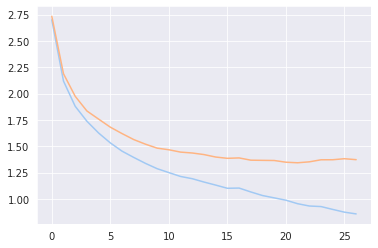

In [14]:
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(loss_per_epoch[0])),y=loss_per_epoch[0])
sns.lineplot(x=range(len(loss_per_epoch[1])),y=loss_per_epoch[1])
plt.show()

### **7.Loading and Testing**<a class="anchor" id="7"></a>

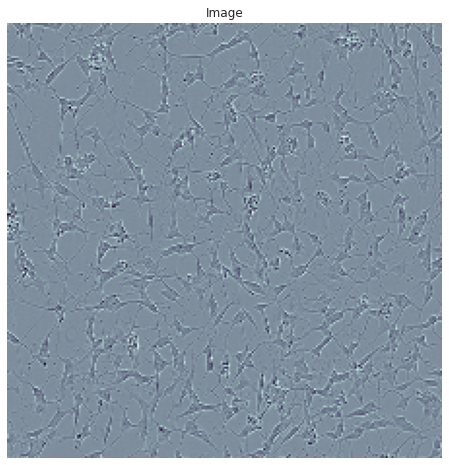

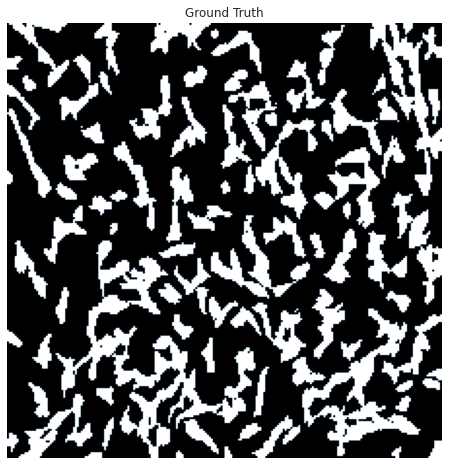

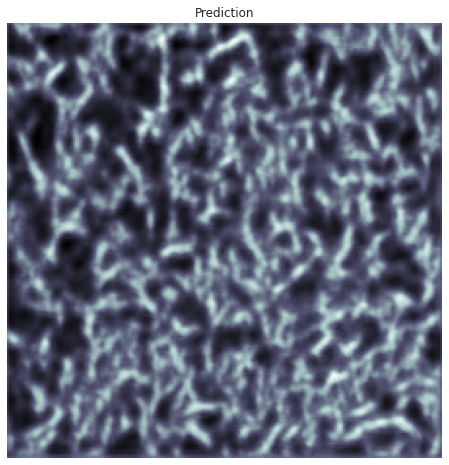

In [15]:
# model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)
# model.to(device)
# model.load_state_dict(torch.load('unet_ss', map_location='cuda'))
with torch.no_grad():
    for _batch_idx_ , (images ,masks) in enumerate(validation_dataloader):
        images, masks_target = images.to(device),  masks.to(device)
        masks_out = model(images)

images = images.cpu().detach().numpy()
masks_out = masks_out.cpu().detach().numpy()
masks_target = masks_target.cpu().detach().numpy()

for i in range(1):
    image = images[i][0]
    mask_out = masks_out[i].reshape((IMG_SIZE[0], IMG_SIZE[1]))
    mask_target = masks_target[i].reshape((IMG_SIZE[0], IMG_SIZE[1]))
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image , cmap = 'bone')
    plt.title("Image")
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(mask_target , cmap = 'bone')
    plt.title("Ground Truth")
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(mask_out , cmap = 'bone')
    plt.title("Prediction")
    plt.axis("off")
    plt.show()

### **8.Predictions**<a class="anchor" id="8"></a>

In [16]:
class TestDataset(Dataset):
    def __init__(self, root,transforms = None):
        self.root = root
        self.transforms = transforms
        self.img_name = []
        for i in os.listdir(root+'test/'):
            self.img_name.append(i[:-4])
        self.w , self.h = 520 , 704

            
    def __getitem__(self, idx):
        image = Image.open(self.root+'test/'+self.img_name[idx]+'.png').convert("RGB")
        if self.transforms is not None:
            image = self.transforms(image=np.array(image))['image']
        
        return {'image': image, 'id': self.img_name[idx]}

    def __len__(self):
        return len(self.img_name)
    

td = TestDataset(root, transforms=get_transform(train=False))
test_loader = DataLoader(td, batch_size=3, shuffle=False)

In [17]:
model.eval()

submission = []
for i, batch in enumerate(test_loader):
    preds = torch.sigmoid(model(batch['image'].cuda()))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for image_id, probability_mask in zip(batch['id'], preds):
        try:
            #if probability_mask.shape != IMAGE_RESIZE:
            #    probability_mask = cv2.resize(probability_mask, dsize=IMAGE_RESIZE, interpolation=cv2.INTER_LINEAR)
            probability_mask = cv2.resize(probability_mask, dsize=(704, 520), interpolation=cv2.INTER_LINEAR)
            predictions = post_process(probability_mask)
            for prediction in predictions:
                #plt.imshow(prediction)
                #plt.show()
                try:
                    submission.append((image_id, rle_encoding(prediction)))
                except:
                    print("Error in RL encoding")
        except Exception as e:
            print(f"Exception for img: {image_id}: {e}")
        
        # Fill images with no predictions
        image_ids = [image_id for image_id, preds in submission]
        if image_id not in image_ids:
            submission.append((image_id, ""))
            
df_submission = pd.DataFrame(submission, columns=['id', 'predicted'])
df_submission.to_csv('submission.csv', index=False)

if df_submission['predicted'].apply(check_is_run_length).mean() != 1:
    print("Check run lenght failed")
    create_empty_submission()



In [18]:
df_submission.groupby('id')['predicted'].agg(lambda x: list(x)).reset_index()

,id,predicted
0,7ae19de7bc2a,[53 19 757 19 1460 20 2164 20 2867 21 3571 20 4274 20 4977 20 5680 20 6383 20 7086 20 7789 20 8493 18 9196 18 9899 18 106...
1,d48ec7815252,[70 12 774 12 1478 13 2182 13 2844 4 2886 14 3545 11 3590 15 4246 16 4294 14 4947 21 4998 14 5651 23 5702 14 6355 26 6406...
2,d8bfd1dafdc4,[117 22 167 81 343 35 821 22 871 81 1047 37 1525 22 1575 83 1750 40 2229 22 2279 84 2454 42 2933 22 2983 85 3158 44 3638 ...
